<a href="https://colab.research.google.com/github/yalangun/tsp-guided-local-search/blob/main/TSPhackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- THE SHERIFF v3 | Seed: 12345 | File: coordinates.csv ---
Şehir sayısı: 532
Veriler hazırlanıyor (distance matrix + neighbors)... tamam.
Multi-start greedy (40) + 2-opt (cezasız) aranıyor...
  start 10/40 | best_init: 6057.37
  start 20/40 | best_init: 6057.37
  start 30/40 | best_init: 6047.19
  start 40/40 | best_init: 6047.19

Başlangıç(best_init): 6047.1884 | lambda=3.410069
>>> GLS devrede (top-k ceza) + strong kick + no-improve reset <<<

🔥 YENİ REKOR: 6040.9293 | dk: 0.00

🔥 YENİ REKOR: 6036.6648 | dk: 0.00

🔥 YENİ REKOR: 6034.7778 | dk: 0.00

🔥 YENİ REKOR: 6027.1900 | dk: 0.00

🔥 YENİ REKOR: 6022.7674 | dk: 0.00

🔥 YENİ REKOR: 6021.7680 | dk: 0.00

🔥 YENİ REKOR: 6018.4719 | dk: 0.00

🔥 YENİ REKOR: 6016.5766 | dk: 0.00

🔥 YENİ REKOR: 6001.6990 | dk: 0.00

🔥 YENİ REKOR: 5991.5260 | dk: 0.01

🔥 YENİ REKOR: 5977.9140 | dk: 0.01

🔥 YENİ REKOR: 5976.1921 | dk: 0.01

🔥 YENİ REKOR: 5973.6951 | dk: 0.01

🔥 YENİ REKOR: 5970.2521 | dk: 0.01

🔥 YENİ REKOR: 5967.0974 | dk: 0.01

🔥 YENİ R

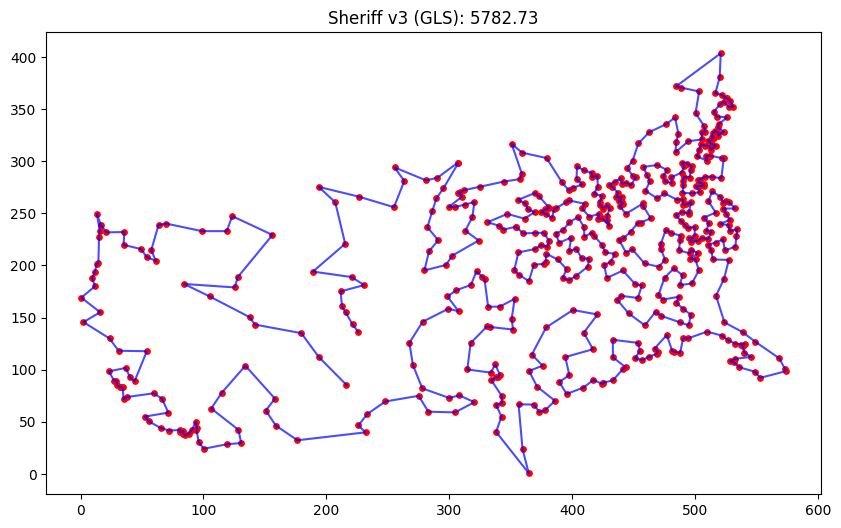

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import njit
import sys
import os

# =============================================================================
# TSP "THE SHERIFF v3" (GLS + 2-OPT + STRONG KICK + NO-IMPROVE RESET)
# Amaç: 5780 duvarını kırmak (532 şehir).
# =============================================================================
DOSYA_YOLU = 'coordinates.csv'
ZAMAN_LIMITI_DK = 30
SEED_NO = 12345

NEIGHBOR_COUNT = 100
MULTISTART = 40

LAMBDA_FACTOR = 0.30      # sabit lambda = factor * (best_init / n)
TOPK_PENALIZE = 8

KICK_EVERY = 100
NO_IMPROVE_LIMIT = 400

REPORT_EVERY = 500
# =============================================================================

np.random.seed(SEED_NO)

def find_file():
    files = os.listdir('.')
    cand = []
    for f in files:
        fl = f.lower()
        if ('coord' in fl) and (fl.endswith('.csv') or fl.endswith('.txt')):
            cand.append(f)
    if cand:
        for f in cand:
            if f.lower() == 'coordinates.csv':
                return f
        return cand[0]
    return DOSYA_YOLU

def read_coords(file_path):
    # whitespace veya csv dene
    try:
        df = pd.read_csv(file_path, sep=r'\s+', header=None)
    except:
        df = pd.read_csv(file_path, header=None)

    if df.shape[1] == 2:
        df.columns = ['x', 'y']
        df.insert(0, 'id', np.arange(len(df), dtype=int))
    else:
        df = df.iloc[:, :3].copy()
        df.columns = ['id', 'x', 'y']
    return df

def precompute_data(coords):
    print("Veriler hazırlanıyor (distance matrix + neighbors)...", end="")
    diff = coords[:, None, :] - coords[None, :, :]
    d_mat = np.sqrt((diff ** 2).sum(axis=-1)).astype(np.float64)
    neighbors = np.argsort(d_mat, axis=1)[:, 1:NEIGHBOR_COUNT+1].astype(np.int32)
    print(" tamam.")
    return d_mat, neighbors

@njit(fastmath=True)
def run_2opt_gls(tour, d_mat, penalties, lambda_val, neighbors):
    n = len(tour)
    pos = np.empty(n, dtype=np.int32)
    for i in range(n):
        pos[tour[i]] = i

    improved = True
    while improved:
        improved = False

        for i in range(n):
            a = tour[i]
            b = tour[(i + 1) % n]

            for kk in range(neighbors.shape[1]):
                c = neighbors[a, kk]
                if c == b:
                    continue

                j = pos[c]
                d = tour[(j + 1) % n]

                # trivial / komşu durumlar
                if j == i:
                    continue
                if (i + 1) % n == j:
                    continue
                if (j + 1) % n == i:
                    continue

                # wrap-around riskini pas geç (stabilite)
                p1, p2 = i, j
                if p2 < p1:
                    p1, p2 = p2, p1
                if p2 - p1 >= n - 2:
                    continue

                dist_old = d_mat[a, b] + d_mat[c, d]
                dist_new = d_mat[a, c] + d_mat[b, d]

                pen_old = penalties[a, b] + penalties[c, d]
                pen_new = penalties[a, c] + penalties[b, d]

                cost_old = dist_old + lambda_val * pen_old
                cost_new = dist_new + lambda_val * pen_new

                if cost_new < cost_old - 1e-12:
                    tour[p1+1:p2+1] = tour[p1+1:p2+1][::-1]
                    for x in range(p1+1, p2+1):
                        pos[tour[x]] = x
                    improved = True
                    break

            if improved:
                break

    return tour

@njit(fastmath=True)
def calc_real_dist(tour, d_mat):
    n = len(tour)
    total = 0.0
    for i in range(n):
        total += d_mat[tour[i], tour[(i + 1) % n]]
    return total

@njit(fastmath=True)
def penalize_topk(tour, d_mat, penalties, K):
    n = len(tour)
    for _ in range(K):
        max_util = -1.0
        max_i = -1
        for i in range(n):
            u = tour[i]
            v = tour[(i + 1) % n]
            util = d_mat[u, v] / (1.0 + penalties[u, v])
            if util > max_util:
                max_util = util
                max_i = i
        u = tour[max_i]
        v = tour[(max_i + 1) % n]
        penalties[u, v] += 1
        penalties[v, u] += 1
    return penalties

def greedy_tour_from(start, d_mat):
    n = d_mat.shape[0]
    unv = np.ones(n, dtype=np.bool_)
    tour = np.empty(n, dtype=np.int32)
    cur = start
    tour[0] = cur
    unv[cur] = False
    for i in range(1, n):
        dists = d_mat[cur].copy()
        dists[~unv] = 1e30
        nxt = int(np.argmin(dists))
        tour[i] = nxt
        unv[nxt] = False
        cur = nxt
    return tour

def double_bridge_kick(tour):
    n = len(tour)
    a = np.random.randint(1, n // 4)
    b = np.random.randint(n // 4, n // 2)
    c = np.random.randint(n // 2, 3 * n // 4)
    d = np.random.randint(3 * n // 4, n - 1)
    p = tour.copy()
    new = np.concatenate([p[:a], p[b:c], p[a:b], p[c:d], p[d:]])
    return new.astype(np.int32)

def kick_strong(tour):
    t = double_bridge_kick(tour)
    n = len(t)
    for _ in range(2):
        i = np.random.randint(0, n)
        j = np.random.randint(0, n)
        t[i], t[j] = t[j], t[i]
    return t.astype(np.int32)

def solve_sheriff_v3():
    file_path = find_file()
    print(f"--- THE SHERIFF v3 | Seed: {SEED_NO} | File: {file_path} ---")

    try:
        df = read_coords(file_path)
    except Exception as e:
        print("Dosya okunamadı!", e)
        return None, None, None, None

    coords = df[['x', 'y']].values.astype(np.float64)
    ids = df['id'].values
    n = len(coords)
    print("Şehir sayısı:", n)

    d_mat, neighbors = precompute_data(coords)
    penalties = np.zeros((n, n), dtype=np.int32)

    # MULTI-START
    print(f"Multi-start greedy ({MULTISTART}) + 2-opt (cezasız) aranıyor...")
    best_init = None
    best_init_dist = 1e30

    for sidx in range(MULTISTART):
        s = np.random.randint(0, n)
        t0 = greedy_tour_from(s, d_mat)
        t0 = run_2opt_gls(t0, d_mat, penalties, 0.0, neighbors)
        d0 = calc_real_dist(t0, d_mat)
        if d0 < best_init_dist:
            best_init_dist = d0
            best_init = t0.copy()

        if (sidx + 1) % 10 == 0:
            print(f"  start {sidx+1}/{MULTISTART} | best_init: {best_init_dist:.2f}")

    current_tour = best_init
    global_best_tour = current_tour.copy()
    global_best_dist = best_init_dist

    # lambda SABİT
    lambda_val = LAMBDA_FACTOR * (best_init_dist / n)

    print(f"\nBaşlangıç(best_init): {global_best_dist:.4f} | lambda={lambda_val:.6f}")
    print(">>> GLS devrede (top-k ceza) + strong kick + no-improve reset <<<")

    start_time = time.time()
    time_limit = ZAMAN_LIMITI_DK * 60

    iter_count = 0
    no_improve = 0
    OUTPUT_FILE = "TSP_SHERIFF_BEST.txt"

    try:
        while True:
            if time.time() - start_time > time_limit:
                print("\nSÜRE DOLDU.")
                break

            iter_count += 1

            # 1) 2-opt GLS
            current_tour = run_2opt_gls(current_tour, d_mat, penalties, lambda_val, neighbors)

            # 2) gerçek mesafe
            real_dist = calc_real_dist(current_tour, d_mat)

            # 3) rekor kontrol
            if real_dist < global_best_dist - 1e-6:
                global_best_dist = real_dist
                global_best_tour = current_tour.copy()
                no_improve = 0

                print(f"\n🔥 YENİ REKOR: {global_best_dist:.4f} | dk: {(time.time()-start_time)/60:.2f}")

                with open(OUTPUT_FILE, 'w') as f:
                    f.write(f"Shortest Distance: {global_best_dist}\n")
                    f.write(f"Tour Sequence: {list(ids[global_best_tour])}\n")
            else:
                no_improve += 1

            # 4) ceza kes (top-k)
            penalties = penalize_topk(current_tour, d_mat, penalties, TOPK_PENALIZE)

            # 5) periyodik kick
            if iter_count % KICK_EVERY == 0:
                current_tour = kick_strong(current_tour)

            # 6) uzun süre rekor yoksa: best'e dön + kick
            if no_improve >= NO_IMPROVE_LIMIT:
                current_tour = global_best_tour.copy()
                current_tour = kick_strong(current_tour)
                no_improve = 0

            # 7) rapor
            if iter_count % REPORT_EVERY == 0:
                elapsed = (time.time() - start_time) / 60.0
                sys.stdout.write(
                    f"\rIter: {iter_count} | Best: {global_best_dist:.2f} | Curr: {real_dist:.2f} | noImp: {no_improve} | dk: {elapsed:.1f}"
                )
                sys.stdout.flush()

    except KeyboardInterrupt:
        print("\nDurduruldu.")

    return global_best_tour, global_best_dist, ids, df

if __name__ == "__main__":
    final_tour, final_dist, city_ids, df = solve_sheriff_v3()

    if final_tour is not None:
        print("\nFINAL BEST:", final_dist)

        plt.figure(figsize=(10, 6))
        plt.plot(df.iloc[final_tour]['x'].values, df.iloc[final_tour]['y'].values, 'b-', alpha=0.7)
        plt.scatter(df['x'].values, df['y'].values, c='red', s=15)
        plt.title(f"Sheriff v3 (GLS): {final_dist:.2f}")
        plt.show()
